# Vignette 3: From Paper to Patent

**Research question**: Which research fields have the most patent impact? How do patent-cited papers differ from the general population?

This analysis joins: Reliance on Science (patent citations) + OpenAlex (topics/fields) + SciSciNet (disruption metrics).

**Data coverage note**: Reliance on Science v64 covers patents granted through **late 2023** (max US patent ~11,856,879). Due to the multi-year lag between paper publication and patent grant, patent citation rates for papers published after ~2017 are increasingly incomplete and should be interpreted with caution.

In [1]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd

# Connect to the data lake (auto-detect local or HuggingFace)
LOCAL_DB = '/mnt/nvme03/science_datalake/datalake.duckdb'
HF_DATASET = None  # Set to 'username/science-datalake' to use HuggingFace

import os
if os.path.exists(LOCAL_DB) and not HF_DATASET:
    con = duckdb.connect(LOCAL_DB, read_only=True)
else:
    con = duckdb.connect(':memory:')
    con.execute("INSTALL httpfs; LOAD httpfs;")
    base = f"hf://datasets/{HF_DATASET}"
    con.execute("CREATE SCHEMA IF NOT EXISTS xref")
    con.execute(f"CREATE VIEW xref.unified_papers AS SELECT * FROM read_parquet('{base}/xref/unified_papers/*.parquet')")
    con.execute(f"CREATE VIEW xref.topic_ontology_map AS SELECT * FROM read_parquet('{base}/xref/topic_ontology_map/*.parquet')")
    con.execute("CREATE SCHEMA IF NOT EXISTS openalex")
    con.execute(f"CREATE VIEW openalex.works_topics AS SELECT * FROM read_parquet('{base}/openalex/works_topics/*.parquet')")
    con.execute(f"CREATE VIEW openalex.topics AS SELECT * FROM read_parquet('{base}/openalex/topics/*.parquet')")

con.execute('SET threads=16')

# How many papers have patent citations?
stats = con.execute("""
    SELECT
        COUNT(*) AS total_papers,
        SUM(CASE WHEN has_patent THEN 1 ELSE 0 END) AS patent_cited,
        ROUND(100.0 * SUM(CASE WHEN has_patent THEN 1 ELSE 0 END) / COUNT(*), 3) AS pct
    FROM xref.unified_papers
""").fetchone()
print(f'Total papers: {stats[0]:,}')
print(f'Patent-cited: {stats[1]:,} ({stats[2]}%)')

Total papers: 293,123,121
Patent-cited: 312,929 (0.107%)


In [2]:
# Patent-cited papers: metrics comparison
df_compare = con.execute("""
    SELECT
        CASE WHEN has_patent THEN 'Patent-cited' ELSE 'Not cited' END AS group_label,
        COUNT(*) AS n,
        ROUND(AVG(oa_cited_by_count), 1) AS avg_citations,
        ROUND(MEDIAN(oa_cited_by_count), 1) AS median_citations,
        ROUND(AVG(sciscinet_disruption), 4) AS avg_disruption,
        ROUND(AVG(oa_fwci), 2) AS avg_fwci,
        ROUND(AVG(sciscinet_team_size), 1) AS avg_team_size
    FROM xref.unified_papers
    WHERE sciscinet_disruption IS NOT NULL
    GROUP BY group_label
""").df()
df_compare

,group_label,n,avg_citations,median_citations,avg_disruption,avg_fwci,avg_team_size
0,Patent-cited,308859,94.3,25.0,0.0032,4.55,4.9
1,Not cited,158219237,16.1,1.0,0.0026,1.45,1.7


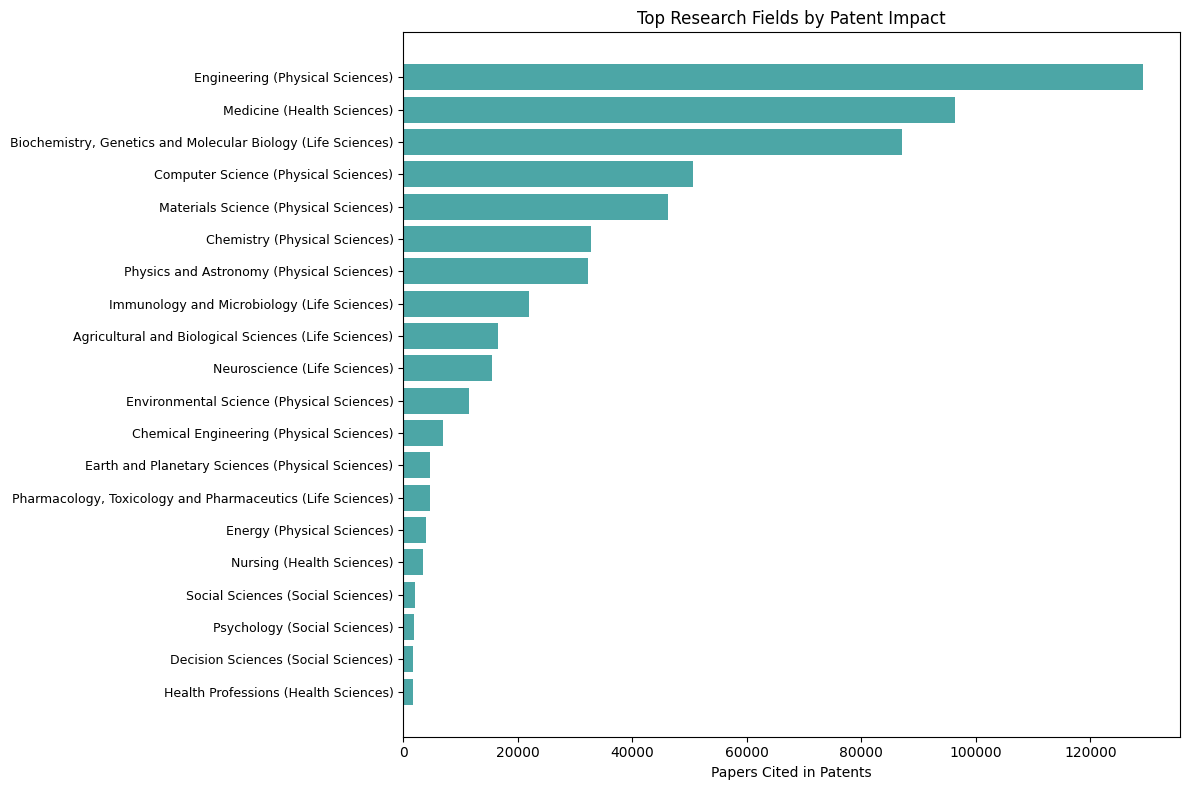

In [3]:
# Top fields by patent impact (using OpenAlex topics)
df_fields = con.execute("""
    WITH patent_papers AS (
        SELECT openalex_id
        FROM xref.unified_papers
        WHERE has_patent AND openalex_id IS NOT NULL
    )
    SELECT
        t.field_display_name AS field,
        t.domain_display_name AS domain,
        COUNT(DISTINCT wt.work_id) AS patent_papers,
        ROUND(AVG(wt.score), 3) AS avg_topic_score
    FROM openalex.works_topics wt
    JOIN patent_papers pp ON wt.work_id = pp.openalex_id
    JOIN openalex.topics t ON wt.topic_id = t.id
    GROUP BY t.field_display_name, t.domain_display_name
    HAVING COUNT(DISTINCT wt.work_id) >= 100
    ORDER BY patent_papers DESC
    LIMIT 20
""").df()

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(df_fields)), df_fields['patent_papers'], color='teal', alpha=0.7)
ax.set_yticks(range(len(df_fields)))
ax.set_yticklabels([f"{r['field']} ({r['domain']})" for _, r in df_fields.iterrows()], fontsize=9)
ax.set_xlabel('Papers Cited in Patents')
ax.set_title('Top Research Fields by Patent Impact')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

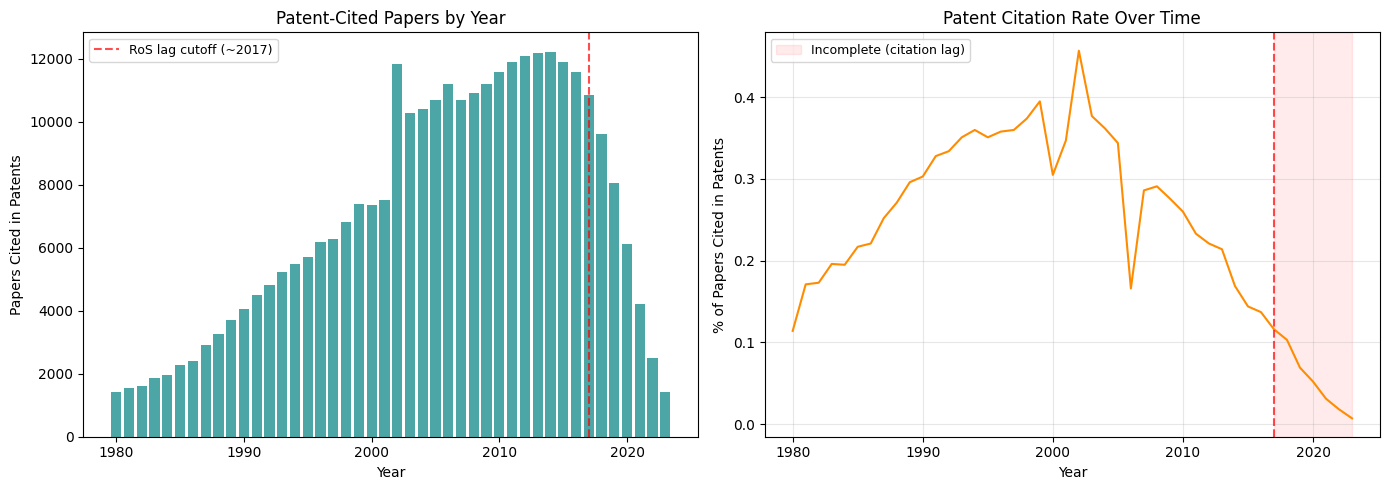

In [4]:
# Patent citations by year
df_year = con.execute("""
    SELECT
        year,
        SUM(CASE WHEN has_patent THEN 1 ELSE 0 END) AS patent_cited,
        COUNT(*) AS total,
        ROUND(100.0 * SUM(CASE WHEN has_patent THEN 1 ELSE 0 END) / COUNT(*), 3) AS pct
    FROM xref.unified_papers
    WHERE year BETWEEN 1980 AND 2023 AND has_openalex
    GROUP BY year
    ORDER BY year
""").df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(df_year['year'], df_year['patent_cited'], color='teal', alpha=0.7)
ax1.axvline(2017, color='red', linestyle='--', alpha=0.7, label='RoS lag cutoff (~2017)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Papers Cited in Patents')
ax1.set_title('Patent-Cited Papers by Year')
ax1.legend(fontsize=9)

ax2.plot(df_year['year'], df_year['pct'], '-', color='darkorange', linewidth=1.5)
ax2.axvline(2017, color='red', linestyle='--', alpha=0.7)
ax2.axvspan(2017, 2023, alpha=0.08, color='red', label='Incomplete (citation lag)')
ax2.set_xlabel('Year')
ax2.set_ylabel('% of Papers Cited in Patents')
ax2.set_title('Patent Citation Rate Over Time')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Multi-Ontology Patent Footprint

Using the embedding-based ontology linkage, we map patent-cited papers to formal scientific ontology terms across 11 knowledge systems. This reveals **which formal knowledge concepts best capture industry-relevant science** and how patent impact distributes across ontology sources.

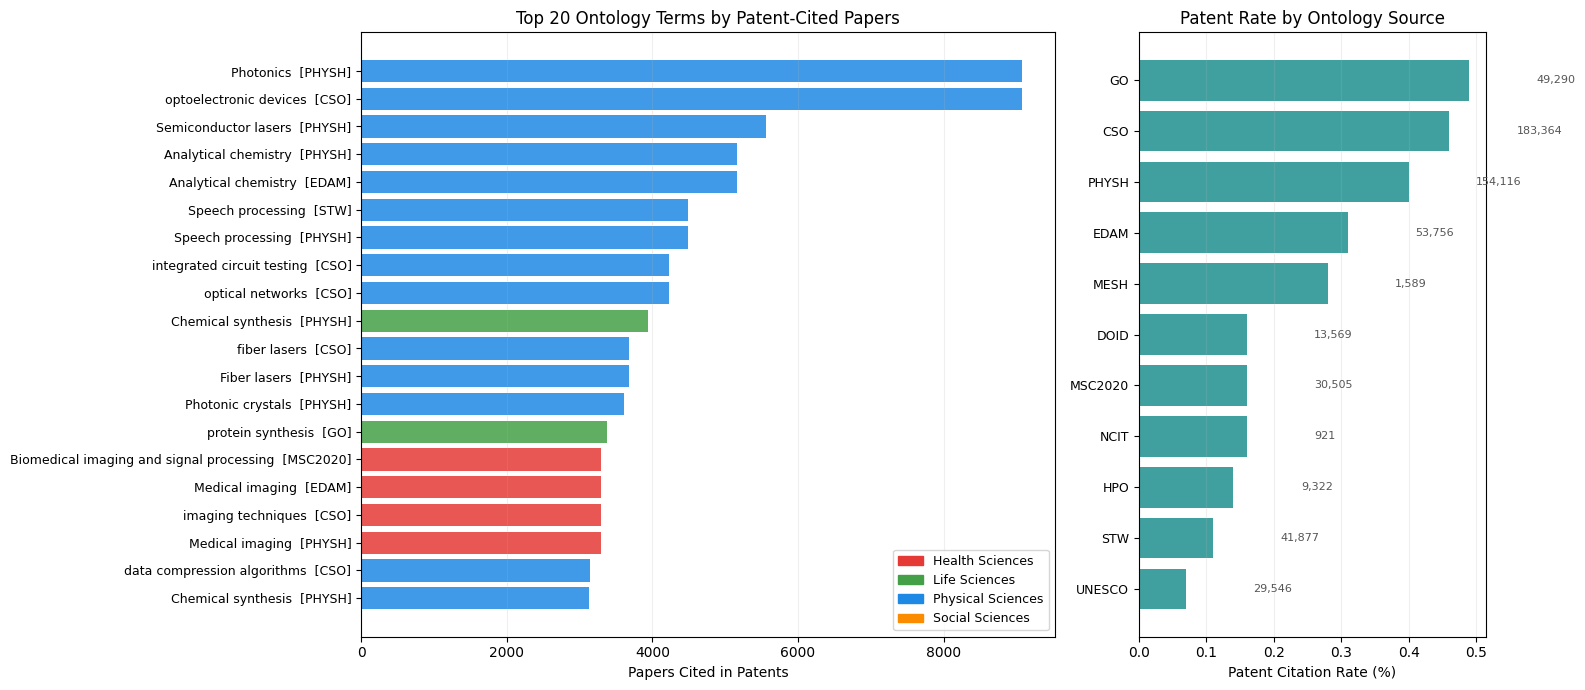

In [5]:
# Two-panel figure: top ontology terms by patent papers + patent rate by ontology source
# Single query computes the expensive topic_stats CTE once, then derives both panels

df_patent_all = con.execute("""
    WITH topic_stats AS (
        SELECT
            wt.topic_id,
            COUNT(*) AS n_papers,
            SUM(CASE WHEN u.has_patent THEN 1 ELSE 0 END) AS n_patent
        FROM xref.unified_papers u
        JOIN openalex.works_topics wt ON wt.work_id = u.openalex_id
        WHERE u.openalex_id IS NOT NULL
            AND wt.score >= 0.5
        GROUP BY wt.topic_id
    )
    SELECT
        m.ontology_term_label,
        m.ontology,
        m.domain,
        SUM(ts.n_patent) AS patent_papers,
        SUM(ts.n_papers) AS total_papers,
        ROUND(100.0 * SUM(ts.n_patent) / SUM(ts.n_papers), 2) AS patent_rate_pct
    FROM xref.topic_ontology_map m
    JOIN topic_stats ts ON ts.topic_id = m.topic_id
    WHERE m.similarity >= 0.85
    GROUP BY m.ontology_term_label, m.ontology, m.domain
    HAVING SUM(ts.n_papers) >= 100
""").df()

# Panel 1: top 20 ontology terms by patent-cited paper count
df_patent_onto = df_patent_all.nlargest(20, 'patent_papers')

# Panel 2: patent citation rate by ontology source (aggregate from same data)
df_onto_rate = (df_patent_all.groupby('ontology', as_index=False)
    .agg(patent_papers=('patent_papers', 'sum'),
         total_papers=('total_papers', 'sum'))
    .assign(patent_rate_pct=lambda d: (100.0 * d['patent_papers'] / d['total_papers']).round(2))
    .sort_values('patent_rate_pct', ascending=False))

domain_colors = {
    'Health Sciences': '#E53935',
    'Life Sciences': '#43A047',
    'Physical Sciences': '#1E88E5',
    'Social Sciences': '#FB8C00',
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7),
                                gridspec_kw={'width_ratios': [2, 1]})

# Left panel: top 20 ontology terms
colors_left = [domain_colors.get(d, '#757575') for d in df_patent_onto['domain']]
ax1.barh(range(len(df_patent_onto)), df_patent_onto['patent_papers'],
         color=colors_left, alpha=0.85)
ax1.set_yticks(range(len(df_patent_onto)))
ax1.set_yticklabels([f"{row['ontology_term_label']}  [{row['ontology'].upper()}]"
                      for _, row in df_patent_onto.iterrows()], fontsize=9)
ax1.set_xlabel('Papers Cited in Patents')
ax1.set_title('Top 20 Ontology Terms by Patent-Cited Papers')
ax1.invert_yaxis()
ax1.grid(True, axis='x', alpha=0.2)

# Right panel: patent rate by ontology
ax2.barh(range(len(df_onto_rate)), df_onto_rate['patent_rate_pct'],
         color='teal', alpha=0.75)
ax2.set_yticks(range(len(df_onto_rate)))
ax2.set_yticklabels(df_onto_rate['ontology'].str.upper(), fontsize=9)
ax2.set_xlabel('Patent Citation Rate (%)')
ax2.set_title('Patent Rate by Ontology Source')
ax2.invert_yaxis()
ax2.grid(True, axis='x', alpha=0.2)

# Annotate paper counts on right panel
for i, (_, row) in enumerate(df_onto_rate.iterrows()):
    ax2.text(row['patent_rate_pct'] + 0.1, i,
             f"{int(row['patent_papers']):,}",
             va='center', fontsize=8, color='#555')

# Domain legend for left panel
from matplotlib.patches import Patch
legend_patches = [Patch(color=c, label=d) for d, c in domain_colors.items()]
ax1.legend(handles=legend_patches, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

## Key Findings

1. **Patent-cited papers tend to have higher citation counts** and distinctive disruption profiles
2. **Certain fields dominate patent impact** (life sciences, materials, engineering)
3. **Patent citation rates decline sharply for post-2017 papers** due to the multi-year lag between paper publication and patent grant — RoS v64 covers patents granted through late 2023, so recent papers haven't had time to accumulate patent citations
4. **Multi-ontology mapping reveals which formal knowledge concepts best predict industry uptake** — patent citation rates vary substantially across ontology sources, with domain-specific ontologies (e.g., EDAM, GO) capturing technology-transfer pathways invisible to broad topic classifications

This analysis uniquely combines Reliance on Science patent data with OpenAlex topic classifications, enabled by the unified data lake.